# User Subscriptions

## Objectives

Suppose you are working with the Head of Product to get more existing Stripe users to start using the Subscriptions product. Please develop a quantitative approach which identifies a list of users for a sales or marketing campaign.

1. Define metrics to measure users that have been converted to a subscription based.
    - Short-term retention metric
    - Long-term retention metric
2. What merchant should be targeted?
3. How to measure the success of the marketing campaign?
    - Short-term retention metric
    - Long-term retention metric
4. TBD

**Note**: Green Taxis (as opposed to yellow ones) are taxis that are not allowed to pick up passengers inside of the densely populated areas of Manhattan. The data used for analysis is from September 2015.

Most of the fields in the dataset are described by the *Data Dictionary of LPEP Trip Records*, which is linked in the reference below. Other needed information can also be founded in the references.

## References

1. [NYC Taxi & Limousine Commision (TLC) Record Data](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml)
2. [Data Dictionary of Livery Passenger Enhancement Program (LPEP) Trip Records](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
3. [Definition of Rate Code](http://www.nyc.gov/html/tlc/html/industry/taxicab_rate_yellow.shtml)
4. [E-Hail](http://www.nyc.gov/html/tlc/html/news/initiative_e_hail.shtml)

In [1]:
# Import library
import pandas as pd
import numpy as np
import datetime
from pytz import country_timezones
import itertools


import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pprint as pp
import time
from tqdm import tqdm_notebook as tqdm
from IPython.display import IFrame

# Ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for randomization
seed = 0

In [76]:

# TODO: Compile all data cleaning steps into one function with explicit log messages
# TODO: Add docstring for each helper function

# TODO: 1. Deal with time in multiple time zones, convert tz-aware to tz-naive?
# TODO: 2. Convert cent to dollar
# TODO: 3. Create simple definition for subscription user: merchant whose latest transactions all have subscription fee (without stopping use of service). Do cluster analysis to find characteristics of subscription users

# ? Things to think about:
# ? 1. Divide data into cohort by month/country/industry or combinations of multiple factors
# ? 2. Is there any seasonality effect in subscription business? Higher rate of subscription in certain month due to increasing business activities, prior to big holidays and etc?
# ? 3. 

## Step 1: Data Download and Loading

In [1]:
import gdown

In [3]:
data_url = 'https://drive.google.com/drive/folders/1O_kCAIKhj8dzt06DqC8FZ4brdktarjPg?usp=drive_link'
gdown.download_folder(data_url, output = 'data', quiet=True, use_cookies=False)

Retrieving folder list


Processing file 1rMHQCMFJHYTM6UMXSb-vKGfo6vipPKSv Data descriptions.xlsx
Processing file 16VQn_EzeVjfOk8Nke5UhLbunpyVvzNPh dstakehome_merchants.xlsx
Processing file 1EIIOkxmoVLaLxPPJnzANOPa6czm4UQi- dstakehome_payments.xlsx
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1rMHQCMFJHYTM6UMXSb-vKGfo6vipPKSv
To: c:\Users\Kefu Zhu\Desktop\GitHub\Projects\User-Subscription\data\Data descriptions.xlsx
100%|██████████| 8.55k/8.55k [00:00<00:00, 8.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=16VQn_EzeVjfOk8Nke5UhLbunpyVvzNPh
To: c:\Users\Kefu Zhu\Desktop\GitHub\Projects\User-Subscription\data\dstakehome_merchants.xlsx
100%|██████████| 708k/708k [00:00<00:00, 12.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EIIOkxmoVLaLxPPJnzANOPa6czm4UQi-
To: c:\Users\Kefu Zhu\Desktop\GitHub\Projects\User-Subscription\data\dstakehome_payments.xlsx
100%|██████████| 40.5M/40.5M [00:00<00:00, 55.2MB/s]
Download completed


['data\\Data descriptions.xlsx',
 'data\\dstakehome_merchants.xlsx',
 'data\\dstakehome_payments.xlsx']

## Step 2: Data Preprocessing
### Step 2.1: Data cleaning and timestamp conversion

In [2]:
%%time

merchants = pd.read_excel('data/dstakehome_merchants.xlsx', 
                           converters = {'merchant':str,'industry':str, 'first_charge_date':pd.to_datetime,'country':str,'business_size':str})
payments = pd.read_excel('data/dstakehome_payments.xlsx',
                          converters = {'date':pd.to_datetime,'merchant':str,'subscription_volume':int,'checkout_volume':int,'payment_link_volume':int})

CPU times: total: 4min 14s
Wall time: 4min 17s


In [3]:
# Check if the raw data contains any NaN values
print('merchants data contains NaN values: {}'.format(merchants.isnull().values.any()))
print('payments data contains NaN values: {}'.format(payments.isnull().values.any()))

merchants data contains NaN values: False
payments data contains NaN values: False


In [4]:
# Standardize tz-aware and tz-naive instances to UTC based tz-aware datetime
merchants['first_charge_date'] = pd.to_datetime(merchants.first_charge_date, utc = True)
# Convert UTC time to local time zone based on country code
merchants['first_charge_date_localized'] = [date.tz_convert(country_timezones(country)[0]) for date,country in zip(merchants.first_charge_date, merchants.country)]

# Check duplicated merchant ID
print('Merchant unique identifier contains duplicated ID: {}'.format(merchants.merchant.duplicated().any()))
# Show the merchant records with duplicated IDs
display(merchants.loc[merchants.merchant.duplicated(keep = False),:])
# Remove records with abnormal merchant ID
print('{} records are removed due to abnormal merchan ID of 0'.format(sum(merchants.merchant.duplicated(keep = False))))
merchants = merchants.loc[~merchants.merchant.duplicated(keep = False),:]

Merchant unique identifier contains duplicated ID: True


,merchant,industry,first_charge_date,country,business_size,first_charge_date_localized
11282,0,Healthcare,2040-12-08 00:00:00+00:00,US,small,2040-12-07 19:00:00-05:00
11606,0,Merchandise,2038-11-30 00:00:00+00:00,CA,small,2038-11-29 20:30:00-03:30
13020,0,Education,2041-07-15 00:00:00+00:00,MX,small,2041-07-14 18:00:00-06:00
13384,0,Others,2041-07-24 00:00:00+00:00,GB,small,2041-07-24 00:00:00+00:00
18458,0,Business services,2041-12-16 00:00:00+00:00,US,small,2041-12-15 19:00:00-05:00
20739,0,Others,2042-03-10 00:00:00+00:00,US,small,2042-03-09 19:00:00-05:00
21151,0,Others,2042-03-26 00:00:00+00:00,GB,small,2042-03-26 00:00:00+00:00
22686,0,Leisure,2042-05-22 00:00:00+00:00,SG,small,2042-05-22 08:00:00+08:00


8 records are removed due to abnormal merchan ID of 0


In [5]:
# Convert the all transaction volumes from cents to dollars
payments[['subscription_volume','checkout_volume','payment_link_volume','total_volume']] = payments[['subscription_volume','checkout_volume','payment_link_volume','total_volume']].apply(lambda x: x/100)
# Drop transaction records with unidentified merchant ID of 0
payments = payments.loc[payments.merchant != '0',:]
# Merge payments and merchants data based on merchant ID (Note: This step is performed at beginning in order to leverage all information on the record. Despite some fields might be empty or contain abnormal values, which will be dropped later)
payments_merged = payments.merge(merchants, how = 'left', on = 'merchant')

In [6]:
# Remove merchants records that have abnormal first charge date, due to raw value of 0
minimum_date_record = merchants.first_charge_date_localized == merchants.first_charge_date_localized.min()
print('{} records are removed due to zero value in first charge date field, which appears as datetime of {}'.format(sum(minimum_date_record), merchants.first_charge_date_localized.min()))
merchants = merchants.loc[~minimum_date_record,:]

26 records are removed due to zero value in first charge date field, which appears as datetime of 1969-12-31 19:00:00-05:00


In [7]:
# Standardize tz-aware and tz-naive instances to UTC based tz-aware datetime
payments_merged['date'] = pd.to_datetime(payments_merged.date, utc = True)
# Convert UTC time to local time zone based on country code
payments_merged['date_localized'] = [date.tz_convert(country_timezones(country)[0]) for date,country in zip(payments_merged.date, payments_merged.country)]
# Replace the first column (date) with the last column (date_localized), and drop the original first column
cols = payments_merged.columns.tolist()
cols = [col for col in cols if col not in ['date','first_charge_date']]
new_cols = cols[-2:] + cols[0:-2]
payments_merged = payments_merged[new_cols]


In [14]:
payments_merged.head()

,first_charge_date_localized,date_localized,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,industry,country,business_size
0,2032-02-12 19:00:00-05:00,2041-04-30 19:00:00-05:00,5d03e714,0.0,0.00,0.0,4253.40,Education,US,medium
1,2031-10-15 20:00:00-04:00,2041-04-30 19:00:00-05:00,da22f154,0.0,0.00,0.0,173.26,Others,US,small
2,2032-07-22 20:00:00-04:00,2041-04-30 19:00:00-05:00,687eebc8,794.0,0.00,0.0,794.00,Software,US,small
3,2033-03-14 20:00:00-04:00,2041-04-30 19:00:00-05:00,de478470,2684.0,0.00,0.0,2684.00,Software,US,small
4,2035-02-12 01:00:00+01:00,2041-05-01 01:00:00+01:00,1e719b8a,0.0,198.95,0.0,198.95,Business services,IT,small


In [15]:
# Drop transanction records where the total transaction volume is non-zero but no transcation volume is observerd across all products
zero_transaction_volume = (payments_merged.subscription_volume == 0) & (payments_merged.checkout_volume == 0) & (payments_merged.payment_link_volume == 0) & (payments_merged.total_volume != 0)
print('{} transaction records ({:.2f}%) have zero volume across all three products but with non-zero total volume'.format(sum(zero_transaction_volume), 100*sum(zero_transaction_volume)/payments_merged.shape[0]))
print("This might be due to the merchants have been using other Stripe's product, and this is the majority of the population we should do campaign on. Depending on the customer stickness, higher spend could indicate higher likelyhood to be converted into subscription user")
# Drop transanction records where the total transaction volume is greater than the sum of transaction volumes across all products
incorrect_total_transaction_volume = payments_merged[['subscription_volume', 'checkout_volume', 'payment_link_volume']].sum(axis = 1) > payments_merged.total_volume
print('\nIn addition, {} transaction records ({:.2f}%) have lower total volume than the sum of transaction volumes across all products'.format(sum(incorrect_total_transaction_volume), 100*sum(incorrect_total_transaction_volume)/payments_merged.shape[0]))
display(payments_merged.loc[incorrect_total_transaction_volume,:].head())
# Remove records with incorrect transaction volume
print('Remove records with incorrect transaction volume')
payments_merged = payments_merged.loc[~incorrect_total_transaction_volume,:]


1080620 transaction records (68.49%) have zero volume across all three products but with non-zero total volume
This might be due to the merchants have been using other Stripe's product, and this is the majority of the population we should do campaign on. Depending on the customer stickness, higher spend could indicate higher likelyhood to be converted into subscription user

In addition, 70725 transaction records (4.48%) have lower total volume than the sum of transaction volumes across all products


,first_charge_date_localized,date_localized,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,industry,country,business_size
53,2034-01-09 19:00:00-05:00,2041-04-30 19:00:00-05:00,3a5a0e99,300.00,300.00,0.0,300.00,Leisure,US,small
69,2034-04-11 01:00:00+01:00,2041-05-01 00:00:00+00:00,36171ac2,82.90,439.38,0.0,439.38,Grocery & food stores,GB,small
151,2034-09-29 02:00:00+02:00,2041-05-01 01:00:00+01:00,54243875,395.39,11.90,0.0,395.39,Software,CH,small
192,2040-04-15 00:00:00+00:00,2041-05-01 00:00:00+00:00,7f41705d,31.99,31.99,0.0,31.99,Digital goods,GB,small
206,2038-09-12 19:00:00-05:00,2041-04-30 19:00:00-05:00,aee4309e,12.00,12.00,0.0,12.00,Software,US,small


Remove records with incorrect transaction volume


In [17]:
# Sanity check to see if the merged dataset contains any NaN values
print('Merged dataset contains NaN values: {}'.format(payments_merged.isnull().values.any()))

Merged dataset contains NaN values: False


### Step 2.2 Define subscription users

In [18]:
# Function to find different types of merchants with respect to subscription criterion
def find_subscription_merchants(payments, sub_ratio = 1):
    '''
    TO BE FILLED
    '''
    # Calculate the percentage of transactions each merchant made with subscription fee
    subscription_ratio = payments.groupby('merchant').apply(lambda x: sum(x.subscription_volume != 0))/payments.groupby('merchant').size()
    # Subscription Merchants
    subscription_merchants = subscription_ratio.index.values[subscription_ratio >= sub_ratio]
    # Semi-Subscription Merchants
    semi_subscription_merchants = subscription_ratio.index.values[(subscription_ratio != 0) & (subscription_ratio < sub_ratio)]
    # Non-Subscription Merchants
    non_subscription_merchants = subscription_ratio.index.values[subscription_ratio == 0]

    return subscription_merchants, semi_subscription_merchants, non_subscription_merchants

In [19]:
# Assume subscription users are merchants who uses Stripe's subscription service for all transactions
subscription_merchants, semi_subscription_merchants, non_subscription_merchants = find_subscription_merchants(payments_merged, sub_ratio = 1)

### Step 2.3 Create addtional features to help capture the characteristics of subscription users

1. Business time with Stripe: How long has this merchant been doing business with Stripe before the first transcation using the subscription product
2. Total payment volume with Stripe across all payments/transactions
3. Payment Frequency
- Minimum number of days between two adjacent transactions
- Maximum number of days between two adjacent transactions
4. Most common payment time
- Weekday
- Month
- Quarter

In [159]:
# Create subset of payment records from subscription users only
subscription_payments = payments_merged.loc[payments_merged.merchant.isin(subscription_merchants),:].sort_values(['merchant', 'date_localized'])
subscription_payments.head()

,first_charge_date_localized,date_localized,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,industry,country,business_size
7491,2037-07-01 20:00:00-04:00,2041-05-02 19:00:00-05:00,00314b59,50.0,0.0,0.0,50.0,Merchandise,US,small
116090,2037-07-01 20:00:00-04:00,2041-06-02 19:00:00-05:00,00314b59,50.0,0.0,0.0,50.0,Merchandise,US,small
221776,2037-07-01 20:00:00-04:00,2041-07-02 19:00:00-05:00,00314b59,50.0,0.0,0.0,50.0,Merchandise,US,small
329558,2037-07-01 20:00:00-04:00,2041-08-02 19:00:00-05:00,00314b59,50.0,0.0,0.0,50.0,Merchandise,US,small
440505,2037-07-01 20:00:00-04:00,2041-09-02 19:00:00-05:00,00314b59,50.0,0.0,0.0,50.0,Merchandise,US,small


In [160]:
# Calculate the elapsed time in days between adjacent payments for each merchant
date_diff_adjacent_payment = subscription_payments.date_localized - subscription_payments.shift().date_localized
date_diff_adjacent_payment[subscription_payments.groupby('merchant').head(1).index] = None # Impute the first payment record for each merchant as None
subscription_payments['payment_diff'] = date_diff_adjacent_payment
# Convert payment timestamp to weekday, month, quarter
subscription_payments['weekday'] = subscription_payments.date_localized.apply(lambda x: x.weekday())
subscription_payments['month'] = subscription_payments.date_localized.apply(lambda x: x.month)
subscription_payments['quarter'] = subscription_payments.date_localized.apply(lambda x: x.quarter)

def find_most_frequent_unique_element(lst):

    from collections import Counter
    # Count the occurrences of each element in the list
    counts = Counter(lst)

    # Find the element with the maximum count
    max_count = max(counts.values())

    # Initialize a list to store elements with the maximum count
    most_frequent_elements = []

    # Iterate through the elements and check if they have the maximum count
    for element, count in counts.items():
        if count == max_count:
            most_frequent_elements.append(element)

    # If there is only one element with the maximum count, return it
    if len(most_frequent_elements) == 1:
        return most_frequent_elements[0]
    else:
        return None  # No unique most frequent element found

# Group by
groupby_min = subscription_payments.groupby('merchant').min()
groupby_max = subscription_payments.groupby('merchant').max()
groupby_sum = subscription_payments.groupby('merchant').sum()
groupby_most_freq = subscription_payments.groupby('merchant').agg(find_most_frequent_unique_element)

# Business time with Stripe
business_time = groupby_min.date_localized - groupby_min.first_charge_date_localized
# Total payment volume with Stripe
total_payment_volume = groupby_sum.total_volume
# Payment frequency - minimum number of days between two adjacent transactions
payment_freq_min = groupby_min.payment_diff
# Payment frequency - maximum number of days between two adjacent transactions
payment_freq_max = groupby_max.payment_diff
# Most common payment time - Weekday
common_weekday = groupby_most_freq.weekday
# # Most common payment time - Month
common_month = groupby_most_freq.month
# # Most common payment time - Quarter
common_quarter = groupby_most_freq.quarter

In [161]:
train_data = pd.DataFrame({'merchant': groupby_min.index,
                           'business_time': business_time,
                           'total_payment_volume': total_payment_volume,
                           'payment_freq_min': payment_freq_min,
                           'payment_freq_max': payment_freq_max,
                           'common_weekday': common_weekday,
                           'common_month': common_month,
                           'common_quarter': common_quarter})

In [162]:
train_data.head()

,merchant,business_time,total_payment_volume,payment_freq_min,payment_freq_max,common_weekday,common_month,common_quarter
merchant,,,,,,,,
00314b59,00314b59,1401 days,700.00,28 days,31 days,NaN,NaN,2.0
008f8086,008f8086,0 days,3541.26,1 days,30 days,NaN,4.0,1.0
00c2b70f,00c2b70f,1550 days,2295.05,1 days,12 days,NaN,5.0,2.0
013c05f5,013c05f5,2409 days,5125.00,4 days,16 days,NaN,5.0,2.0
016dd01f,016dd01f,739 days,342.81,8 days,31 days,5.0,12.0,4.0


## Step 3: Data Visualization

In [61]:
payments_merged.describe()

,subscription_volume,checkout_volume,payment_link_volume,total_volume
count,1.577887e+06,1.577887e+06,1.577887e+06,1.577887e+06
mean,3.924766e+04,1.101376e+04,1.843901e+03,3.582914e+05
std,7.253647e+05,1.608574e+05,3.717659e+04,6.488684e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+03
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.987200e+04
75%,0.000000e+00,0.000000e+00,0.000000e+00,7.230000e+04
max,1.083879e+08,3.425907e+07,1.182900e+07,2.243810e+09


In [63]:
t = payments_merged.subscription_volume[payments_merged.subscription_volume!=0]
t

2           79400
3          268400
6           42500
8           26600
9          298662
            ...  
1577878      5700
1577880     12579
1577881     58000
1577883    122686
1577884    278100
Name: subscription_volume, Length: 349539, dtype: int64

In [75]:
t[t>9*(10**7)]

1279315     90159317
1362724     94777154
1420595     94373605
1449714     90638659
1477622     92336558
1505067     94406538
1533653    108387903
1562035    101381217
Name: subscription_volume, dtype: int64

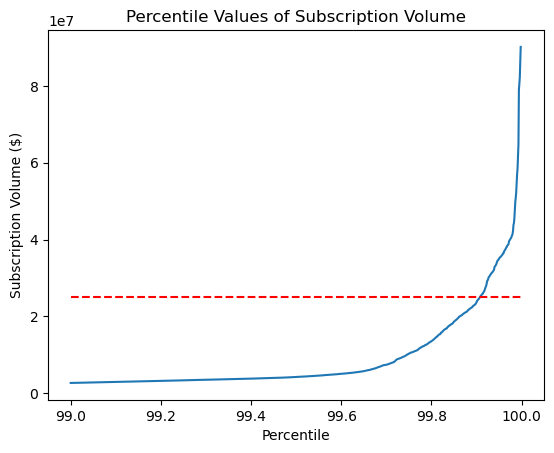

In [70]:
# Compute the value of Trip_distance for percentiles of 99.000, 99.001, ..., 99.999
X = np.arange(99,99.999,0.001)
Y = [np.percentile(t, x) for x in X]
# Visualize the percentile values
ax = sns.lineplot(x = X, y = Y)
ax.hlines(2.5*(10**7), xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') # Add horizontal red dashed line at 30
ax.set_title('Percentile Values of Subscription Volume');
ax.set_xlabel('Percentile'); ax.set_ylabel('Subscription Volume ($)');

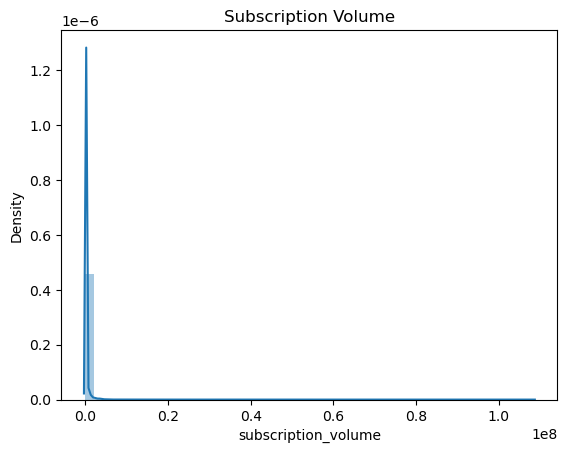

In [62]:
# Plot the histogram of Subscription Volume
ax = sns.distplot(payments_merged.subscription_volume[payments_merged.subscription_volume!=0], kde = True)
ax.set_title('Subscription Volume');

## Step 4. Data
## (1) Plot a histogram of the number of the trip distance (“Trip Distance”)

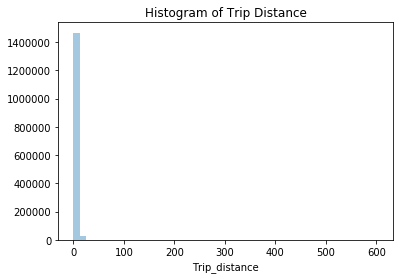

## (2) Report any structure you find and any hypotheses you have about that structure

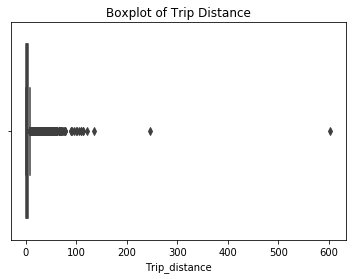

In [11]:
# Draw a boxplot of Trip_distance
ax = sns.boxplot(data.Trip_distance)
ax.set_title('Boxplot of Trip Distance')
ax;

In [12]:
# Get the statistics summary of Trip_distance
data.Trip_distance.describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

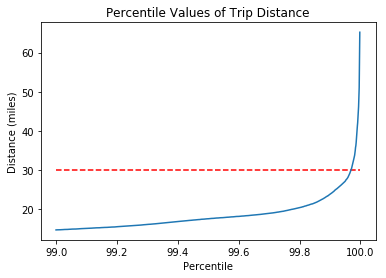

In [13]:
# Compute the value of Trip_distance for percentiles of 99.000, 99.001, ..., 99.999
X = np.arange(99,99.999,0.001)
Y = [np.percentile(data.Trip_distance, x) for x in X]
# Visualize the percentile values
ax = sns.lineplot(x = X, y = Y)
ax.hlines(30, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') # Add horizontal red dashed line at 30
ax.set_title('Percentile Values of Trip Distance');
ax.set_xlabel('Percentile'); ax.set_ylabel('Distance (miles)');

In [14]:
# The index and the value of the percentile that is closest to 30
min(enumerate(Y), key=lambda x: abs(x[1]-30))

(969, 30.061465001381002)

In [15]:
# The percentile that has value of 30 for Trip_distance
print('Roughly {:.2f}% of the trip records have Trip_distance roughly less than 30 miles'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-30))])) 
      # min(range(len(Y)), key=lambda i: abs(Y[i]-30)) = 969

Roughly 99.97% of the trip records have Trip_distance roughly less than 30 miles


In [16]:
# The number of trips that travel over 31 miles
print('The number of trips that travel over 31 miles: {}'
      .format(sum(data['Trip_distance'] > 31)))

The number of trips that travel over 31 miles: 409


### Below is a circle with $31$ mile radius centered at New York City

**Notations on the map**: 
- EWR: Newark Liberty International Airport
- JFK: John F.Kennedy International Airport
- LGA: LaGuardia Airport


![circle](31_mile_circle.png)

**Summary**: Based on the histogram, the distribution of `Trip_distance` is obviously highly right skewed. Most data have small values, and only few records have extremely large values. 

After a closer look, it is clear to say most of the data lie between $0$ and $4$ miles (lower $75\%$ of the data). Furthermore, about $99.97\%$ of the trips only travle for less than roughly $31$ miles, which leaves only $409$ trip records that have travel distance more than that.

After drawing a circle with radius of $31$ miles centering at NYC on the map, since the circle covers the entire NYC area, I think it might be useful to consider removing any records that have `Trip_distance > 60 (2*radius)` from the dataset in the future analysis. However, detailed investigation on those anomalous data are needed to take such action.

In [17]:
# Extract the anomaly data where Trip_distance > 100
anomaly_data = data.loc[data['Trip_distance'] > 100]
# Compute the travel time for anomaly data and combine it with Trip_distance columnwise
test_anomaly = pd.concat([anomaly_data.Trip_distance, 
               pd.DataFrame(anomaly_data.lpep_dropoff_datetime - anomaly_data.lpep_pickup_datetime,
                            columns = ['Trip_time'])], 
               axis = 1)
# Function for records highlighting
def highlight_lessthan(s,minutes,column):
    is_max = pd.Series(data=False, index = s.index)
    is_max[column] = s.loc[column] <= timedelta(minutes = minutes)
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]
# Show the anomaly data with highlighted records
test_anomaly.style.apply(highlight_lessthan, minutes = 11, column=['Trip_time'], axis=1)

,Trip_distance,Trip_time
478080,246.28,0 days 03:37:07
516757,120.13,0 days 03:16:58
885097,100.74,0 days 02:14:37
944537,134.7,0 days 02:16:54
1077032,105.65,0 days 01:58:06
1282594,108.62,0 days 06:36:08
1321961,603.1,0 days 00:10:24
1416994,112.6,0 days 06:09:31
1432692,112.6,0 days 00:00:02
1457965,108.5,0 days 00:00:00


**Hypothesis**: By taking a simple look at a portion of the anomalous data (`Trip_distance > 100`), it is reasonable to speculate that some of these records are either inputed incorrectly or generated by some system malfunctions. For example, the $3$ records highlighted above contain: 
- Two trips that have travel distance of over $100$ miles within seconds
- One trip that travel $600$ miles in $10$ minutes

Such events are obviously impossible in real life.

**Note**: There might be other explanations for these records, which need further investigations.

# Question 3
## (1) Report mean and median trip distance grouped by hour of day

In [18]:
# Create two columns for pickup hour and dropoff hour
data.loc[:, 'lpep_pickup_hour'] = data.lpep_pickup_datetime.apply(lambda x: x.hour)
data.loc[:, 'lpep_dropoff_hour'] = data.lpep_dropoff_datetime.apply(lambda x: x.hour)

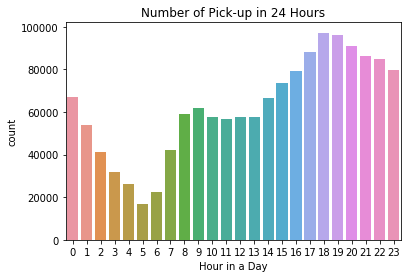

In [19]:
# Sanity check for the distribution of pickup hour
ax = sns.countplot(data['lpep_pickup_hour'])
ax.set_title('Number of Pick-up in 24 Hours')
ax.set_xlabel('Hour in a Day');

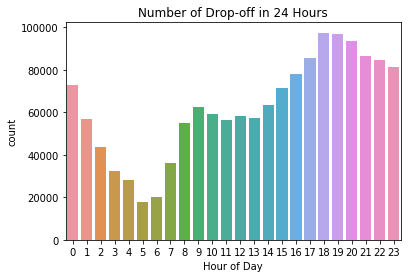

In [20]:
# Sanity check for the distribution of dropoff hour
ax = sns.countplot(data['lpep_dropoff_hour'])
ax.set_title('Number of Drop-off in 24 Hours')
ax.set_xlabel('Hour of Day');

In [21]:
# Create a dataframe to store the mean and median of travel distance for trips that are picked up and droped off in 24 hours
distance_by_hour = pd.DataFrame(columns = ['pickup_mean','dropoff_mean','pickup_median','dropoff_median'])
distance_by_hour.loc[:,'pickup_mean'] = data.groupby(['lpep_pickup_hour']).Trip_distance.mean()
distance_by_hour.loc[:,'pickup_median'] = data.groupby(['lpep_pickup_hour']).Trip_distance.median()
distance_by_hour.loc[:,'dropoff_mean'] = data.groupby(['lpep_dropoff_hour']).Trip_distance.mean()
distance_by_hour.loc[:,'dropoff_median'] = data.groupby(['lpep_dropoff_hour']).Trip_distance.median()
distance_by_hour.index.name = 'Hour'
distance_by_hour

,pickup_mean,dropoff_mean,pickup_median,dropoff_median
Hour,,,,
0,3.115276,3.239356,2.20,2.28
1,3.017347,3.130531,2.12,2.20
2,3.046176,3.143715,2.14,2.21
3,3.212945,3.225473,2.20,2.26
4,3.526555,3.463798,2.36,2.37
5,4.133474,4.187841,2.90,2.92
6,4.055149,3.932660,2.84,2.76
7,3.284394,3.217171,2.17,2.05
8,3.048450,2.923779,1.98,1.87


### Visualize the results

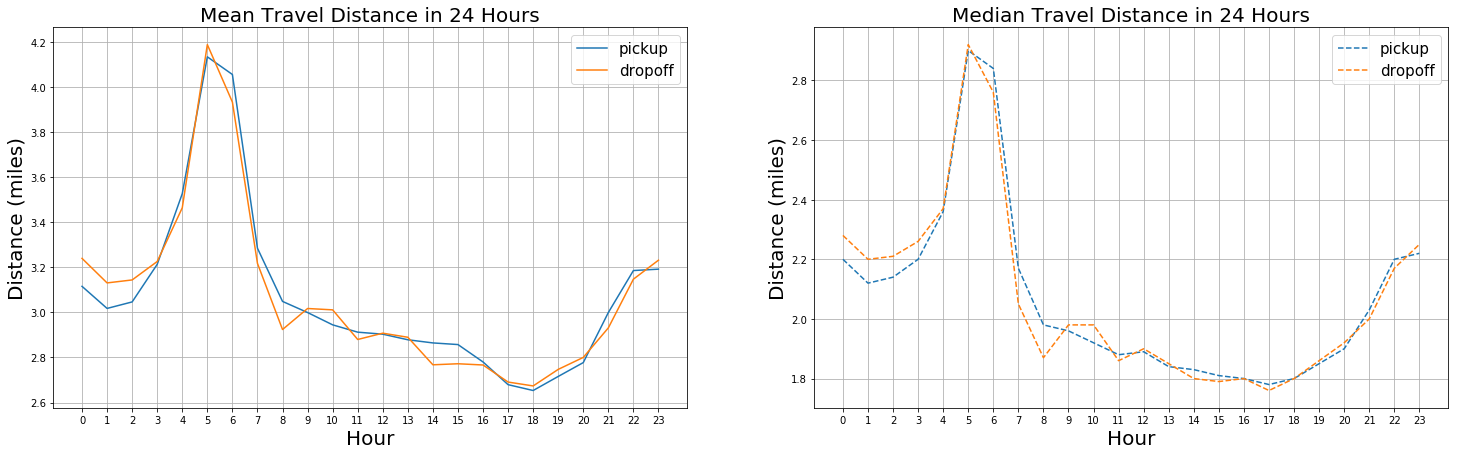

In [22]:
# Create two subplots horizontally aligned (one row, two columns)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(25,7)
# Plot the meana
ax[0].plot(distance_by_hour[['pickup_mean','dropoff_mean']])
ax[0].legend(['pickup','dropoff'], prop={'size':15});ax[0].set_title('Mean Travel Distance in 24 Hours', fontsize = 20)
ax[0].set_xlabel('Hour', fontsize = 20); ax[0].set_ylabel('Distance (miles)', fontsize = 20); ax[0].grid();ax[0].set_xticks(range(24));
# Plot the median
ax[1].plot(distance_by_hour[['pickup_median','dropoff_median']], linestyle = 'dashed')
ax[1].legend(['pickup','dropoff'], prop={'size':15});ax[1].set_title('Median Travel Distance in 24 Hours', fontsize = 20)
ax[1].set_xlabel('Hour', fontsize = 20); ax[1].set_ylabel('Distance (miles)', fontsize = 20); ax[1].grid();ax[1].set_xticks(range(24));

## (2) We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips

In [23]:
print('Among the total of \033[1m{}\033[0m trip records, \n\033[1m{}\033[0m records are trips between JFK International Airport and New York City (RateCodeID = 2)\n\033[1m{}\033[0m records are trips from New York City to Newark Airport (RateCodeID = 3)'
      .format(len(data), sum(data['RateCodeID'] == 2), sum(data['RateCodeID'] == 3)))
print('\nIn general, except possible trips to LaGuardia Airport, which cannot be identified by RateCodeID, \033[1m{:.2f}%\033[0m of the trips are either originate or terminate at one of the NYC area airports'
      .format(100*(sum(data['RateCodeID'].isin([2,3]))/len(data))))

Among the total of 1494926 trip records, 
4435 records are trips between JFK International Airport and New York City (RateCodeID = 2)
1117 records are trips from New York City to Newark Airport (RateCodeID = 3)

In general, except possible trips to LaGuardia Airport, which cannot be identified by RateCodeID, 0.37% of the trips are either originate or terminate at one of the NYC area airports


In [24]:
# Extract trip records that originate or terminate at either JFK or EWR
airport_data = data.query('RateCodeID in (2,3)')
# Other trip records
nonairport_data = data.query('RateCodeID not in (2,3)')
# Compute the average fare amount for trips of JFK and EWR
airport_data.groupby('RateCodeID')['Fare_amount'].mean()

RateCodeID
2    49.021871
3    48.798568
Name: Fare_amount, dtype: float64

Based on the calculation above:
- Trips originate or terminate at JFK airport have average fare of **$49.02**

- Trips terminate at EWR airport have average fare of **$48.80**


In [25]:
print('''Trips that do not originate or terminate at airports have average fare of \033[1m${:.2f}\033[0m,
which is way lower than the numbers above.'''.format(nonairport_data['Fare_amount'].mean()))

Trips that do not originate or terminate at airports have average fare of $12.41,
which is way lower than the numbers above.


### a. Pickup time & Dropoff Time (Airport vs. Nonairport)

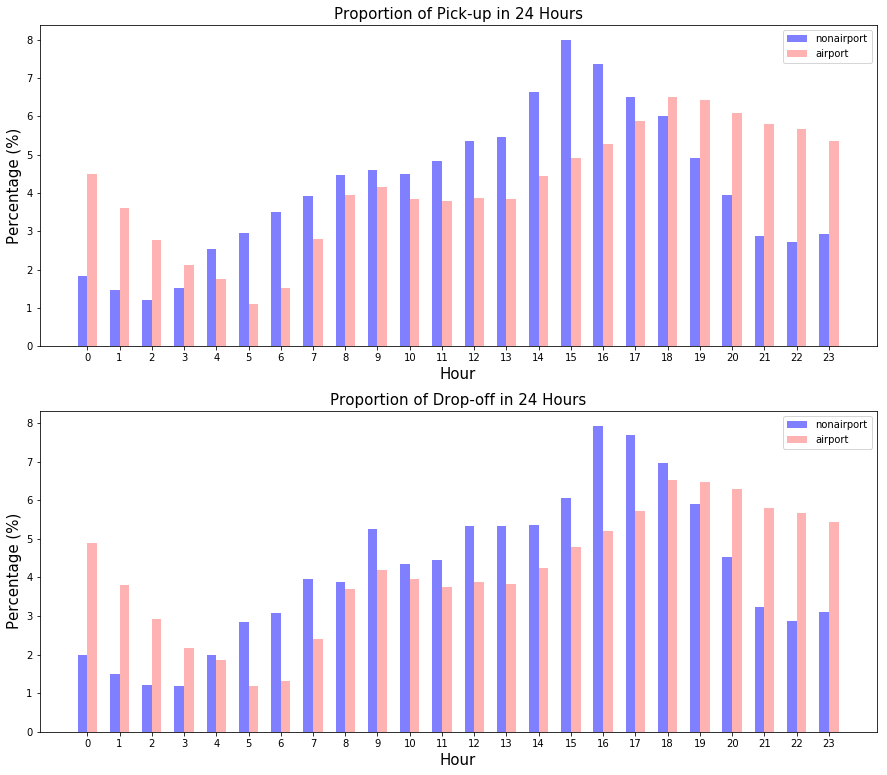

In [26]:
# Compute the percentage of pickup for both airport and nonairport data in 24 hours
airport_pickup = 100 * airport_data.groupby('lpep_pickup_hour')['lpep_pickup_hour'].count() / len(airport_data)
nonairport_pickup = 100 * nonairport_data.groupby('lpep_pickup_hour')['lpep_pickup_hour'].count() / len(nonairport_data)
# Compute the percentage of pickup for both airport and nonairport data in 24 hours
airport_dropoff = 100 * airport_data.groupby('lpep_dropoff_hour')['lpep_dropoff_hour'].count() / len(airport_data)
nonairport_dropoff = 100 * nonairport_data.groupby('lpep_dropoff_hour')['lpep_dropoff_hour'].count() / len(nonairport_data)

# Create two subplots horizontally aligned (one row, two columns)
fig, ax = plt.subplots(2,1,figsize=(15,13))
# Plot pick-up
ax[0].bar(x = np.arange(24) - 0.3, height = airport_pickup, width = 0.3, color = 'blue', alpha = .5, align = 'edge')
ax[0].bar(x = np.arange(24), height = nonairport_pickup, width = 0.3, color = 'red', alpha = .3, align = 'edge')
ax[0].set_title('Proportion of Pick-up in 24 Hours', fontsize = 15); ax[0].set_xticks(range(24)); ax[0].legend(['nonairport','airport']);
ax[0].set_xlabel('Hour', fontsize = 15); ax[0].set_ylabel('Percentage (%)', fontsize = 15);
# Plot drop-off
ax[1].bar(x = np.arange(24) - 0.3, height = airport_dropoff, width = 0.3, color = 'blue', alpha = .5, align = 'edge')
ax[1].bar(x = np.arange(24), height = nonairport_dropoff, width = 0.3, color = 'red', alpha = .3, align = 'edge')
ax[1].set_title('Proportion of Drop-off in 24 Hours', fontsize = 15); ax[1].set_xticks(range(24)); ax[1].legend(['nonairport','airport']);
ax[1].set_xlabel('Hour', fontsize = 15); ax[1].set_ylabel('Percentage (%)', fontsize = 15);

**Note**: From the two barplots above, we can see a clear difference between trips from/to airports and the other trips in terms of pick-up and drop-off time. 

The Green Taxi often picks up or drops off passengers at the airport from late-afternoon to midnight, while it takes passengers for other businesses mostly during daytime.

### b. Trip Distance (Airport vs. Nonairport)

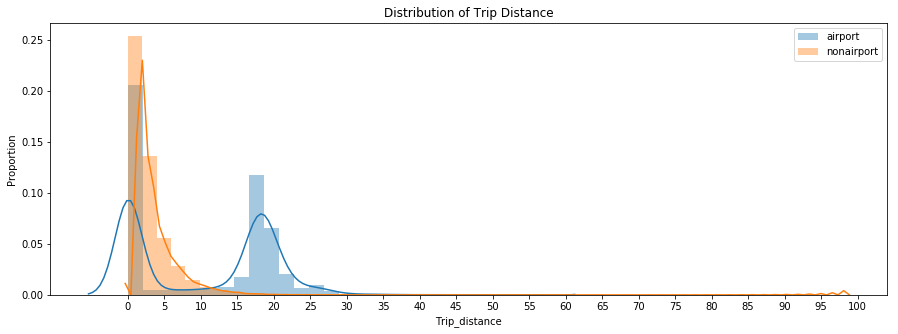

In [27]:
# Plot trip distance for both airport and nonairport data
fig, ax = plt.subplots(figsize = (15,5))
sns.distplot(airport_data[airport_data.Trip_distance < 100].Trip_distance, ax = ax)
sns.distplot(nonairport_data[nonairport_data.Trip_distance < 100].Trip_distance, ax = ax)
ax.legend(['airport','nonairport']); ax.set_title('Distribution of Trip Distance'); ax.set_ylabel('Proportion');
ax.set_xticks(range(0,101,5));

**Note**: I excluded records with `Trip_distance >= 100` because extreme values are not of interest here. Extreme values will destroy the scale of the plot and make other values unreadable. 

Based on the distribution graph above, we can clearly see the difference between travel distance for trips from/to airports and other trips.

**For normal trips**, most of them have travel distance below 10 miles. The distribution of trip distance only has **one peak** that is less than $1$ mile, while the majority of data stay below $5$ miles.

On the other hand, **for trips from/to airports**, the distribution of trip distance has **two peaks**: one is less than $1$ mile, and the other one centered around $20$ miles. The second peak is reasonable to see since many passengers who take taxi from/to airports are from/to urban areas, which are usually located far from airports

### c. Tip Amount (Airport vs. Nonairport)

In [28]:
# Compute the average tip amount for trips of JFK and EWR
airport_data.groupby('RateCodeID').Tip_amount.mean()

RateCodeID
2    4.080232
3    5.438577
Name: Tip_amount, dtype: float64

Based on the calculation above:
- Trips originate or terminate at JFK airport have average tip of **$4.08**

- Trips terminate at EWR airport have average tip of **$5.44**

The numbers are as expected since the EWR airport is further from NYC compared to JFK

In [29]:
print('''Trips that do not originate or terminate at airports have average tip of \033[1m${:.2f}\033[0m,
which is reasonably lower than the numbers above.'''
      .format(nonairport_data.Tip_amount.mean()))

Trips that do not originate or terminate at airports have average tip of $1.22,
which is reasonably lower than the numbers above.


### d. Trip Type (Airport vs. Nonairport)

In [30]:
# Compute the trip type for airport data
print('Trips from/to Airports')
print('-'*40)
print(100 * airport_data.groupby('Trip_type')['Trip_type'].count() / len(airport_data))
print('\n')
print('Normal Trips')
print('-'*40)
print(100 * nonairport_data.groupby('Trip_type')['Trip_type'].count() / len(nonairport_data))

Trips from/to Airports
----------------------------------------
Trip_type
1.0    99.729827
2.0     0.270173
Name: Trip_type, dtype: float64


Normal Trips
----------------------------------------
Trip_type
1.0    97.757111
2.0     2.242620
Name: Trip_type, dtype: float64


From the summary above, we can see a small difference between the type of trip for trips from/to airports and other normal trips. 

It is interesting to see that trips from/to airports are mostly, more than $99$%, street-hail (Type 1). 

While in comparison, about $2$% of the other normal trips from dispatch system (Type 2), despite the majority of them are still from street-hail.

# Question 4
## (1) Build a derived variable for tip as a percentage of the total fare

In [31]:
# Create a new column named "tip_percent_total", for each row:
# - Store the tip as a percentage of the total fareand
# - Store -999.0 if either Tip_amount or Total_amount is invalid
#   (1) Tip_amount should be non-negative
#   (2) Total_amount should be greater than 0
data.loc[:,'tip_percent_total'] = [data.Tip_amount[i]/data.Total_amount[i] if (data.Tip_amount[i] >= 0) & (data.Total_amount[i] > 0) else -999.0 for i in tqdm(data.index)]

Statistics Summary of Tip as Percentage of Total Fare
------------------------------------------------------------
count    602732.000000
mean          0.164551
std           0.057855
min           0.000083
25%           0.161290
50%           0.166667
75%           0.166708
max           1.000000
Name: tip_percent_total, dtype: float64
------------------------------------------------------------
0.00441% of the data have improper (negative) amount of tip as percentage of the total fare


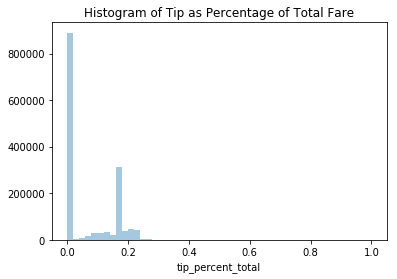

In [32]:
# Plot the distribution of valid tip_percent_total values
ax = sns.distplot(data[data.tip_percent_total >= 0].tip_percent_total, kde = False)
ax.set_title('Histogram of Tip as Percentage of Total Fare');

# Get statistics summary of tip_percent_total
print('Statistics Summary of Tip as Percentage of Total Fare')
print('-' * 60)
print(data[data.tip_percent_total > 0].tip_percent_total.describe())
print('-' * 60)
# Get the percentage of data that has negative tip_percent_total
print('{:.5f}% of the data have improper (negative) amount of tip as percentage of the total fare'
      .format(sum(data.tip_percent_total < 0)/len(data)))

## (2) Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work

### Step 1. Data Exploration

#### A. Create new variables that can potentially help with prediction

Since we are modeling the tip amount as a percentage of the total fare, it is essential to analyze how customers are tipping the driver.

I think we should at least consider the following two basic elements here:

1. **Ride Experience**: Mainly refers to the experience of the actual drive. Such as did the driver arrives target destination in expected time? Was the driver driving too fast or too slow that leads to a bad experience?
2. **Service Experience**: Refers to the other parts of the service, including driver-passengner interactions, extra service like helping with luggages, and etc.


Although it is hard to represent the second element using information within this dataset, we may quantify the first element by creating a new variable:

<br>
<font size = '5'>
<center>
$
mile\ /\ hour = \frac{Trip\_distance\ (miles)}{(Drop\ off\ time\ -\ Pick\ up\ time)\ (hrs)\ +\ 0.0001}
$
</center>
</font>
<br>


**Note**: For simplicity, travel time (hrs) will be round up to four decimal places if applicable. 

The reason to add $0.0001$ at the bottom of the fraction is to avoid division by zero, which will yields `NaN` values. 

In addition, $0.0001$ hour equals to $0.36$ seconds, which basically do not effect the result.


In [33]:
# Create column `mile_per_hour` and compute values for the column
# (The calculation below roughly takes 3 minutes)
data.loc[:,'mile_per_hour'] = [(data.Trip_distance[i])/(0.001 + 
                                round((data.lpep_dropoff_datetime[i] - data.lpep_pickup_datetime[i]).seconds/3600, 4)) 
                                for i in tqdm(data.index)]

Statistics Summary of Mile per Hour
------------------------------------------------------------
count    1.494926e+06
mean     1.496942e+01
std      1.534210e+02
min      0.000000e+00
25%      9.234234e+00
50%      1.166861e+01
75%      1.493437e+01
max      1.085000e+05
Name: mile_per_hour, dtype: float64
------------------------------------------------------------
99.82% of the data has speed less than 100 m/h on average


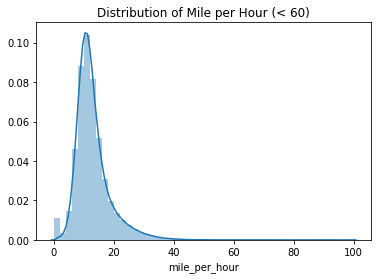

In [34]:
# Plot the distribution of mile_per_hour that is less than 100
ax = sns.distplot(data[data.mile_per_hour < 100].mile_per_hour)
ax.set_title('Distribution of Mile per Hour (< 60)');
# Get statistics summary of tip_percent_total
print('Statistics Summary of Mile per Hour')
print('-' * 60)
print(data.mile_per_hour.describe())
print('-' * 60)
print('{:.2f}% of the data has speed less than 100 m/h on average'
      .format(100 * sum(data.mile_per_hour < 100)/len(data)))

In addition to `lpep_pickup_hour` and `lpep_dropoff_hour`, I also created `lpep_pickup_day` and `lpep_dropoff_day` to decompose and substitute the original `lpep_pickup_datetime` and `lpep_dropoff_datetime`

In [35]:
# Create two columns for pickup day and dropoff day
data.loc[:, 'lpep_pickup_day'] = data.lpep_pickup_datetime.apply(lambda x: x.day)
data.loc[:, 'lpep_dropoff_day'] = data.lpep_dropoff_datetime.apply(lambda x: x.day)

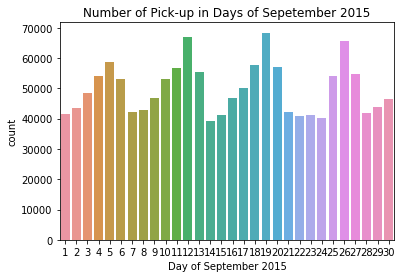

In [36]:
# Sanity check for the distribution of pickup hour
ax = sns.countplot(data.lpep_pickup_day)
ax.set_title('Number of Pick-up in Days of Sepetember 2015')
ax.set_xlabel('Day of September 2015');

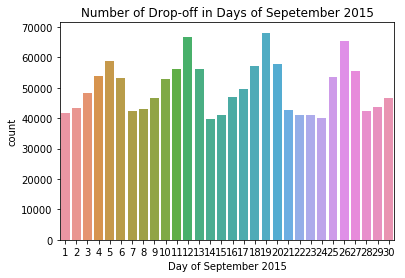

In [37]:
# Sanity check for the distribution of pickup hour
ax = sns.countplot(data.lpep_dropoff_day)
ax.set_title('Number of Drop-off in Days of Sepetember 2015')
ax.set_xlabel('Day of September 2015');

**Note**: From the two plot above, we can see an apparent increase in the number of pick-up and drop-off during weekends

<img src="september_2015.png" alt="Image" height="500" width="500">

#### B. Variables that are not of interest

Some variables that are not of interest here for modeling `tip_percent_total` are `Ehail_fee`, `lpep_pickup_datetime`, `lpep_dropoff_datetime`, `Tip_amount` and `Total_amount`. 

- `Ehail_fee` is not used here because all records are `NaN` for this field.

```python
data.Ehail_fee.isna().all() # True
```

- `lpep_pickup_datetime` and `lpep_dropoff_datetime` are transformed into `lpep_pickup_hour`, `lpep_dropoff_hour`, `lpep_pickup_day` and `lpep_dropoff_day`

- Because we can predicting the tip as a percentage of total fare, it is obvious to exclude `Tip_amount` and `Total_amount` from the predictors.

#### C. Visualize relationship between target variable (`tip_percent_total`) and other useful variables

First of all, it is intuitive to first see the relationships between our target variable, `tip_percent_total`, and other variables. Because the dataset contains too many data points that makse visualization on the entire dataset uneasy, so I sampled 10% of the valid data (`tip_percent_total >= 0`) for the simple visualization purpose



In [38]:
# Sample 10% of valid data for visualization
sample_data = data[data.tip_percent_total >= 0].sample(frac = 0.1, random_state = seed)
sample_data.shape

(148834, 27)

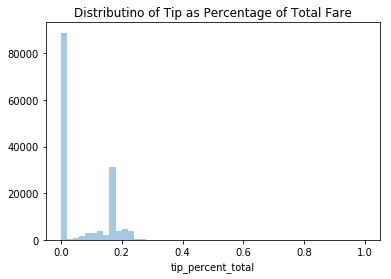

In [39]:
# Plot the distribution of tip_percent_total
ax = sns.distplot(sample_data.tip_percent_total, kde = False)
ax.set_title('Distributino of Tip as Percentage of Total Fare');

##### `Store_and_fwd_flag`

99.42% of the data have 'Y' for 'Store_and_fwd_flag' field
------------------------------------------------------------------------------------------
Although only less than 1% of the data have 'N' value for 'Store_and_fwd_flag', 
from the comparison plot below, we can still see the usefulness of this variable at 
predicting tip as a percentage of total fare.



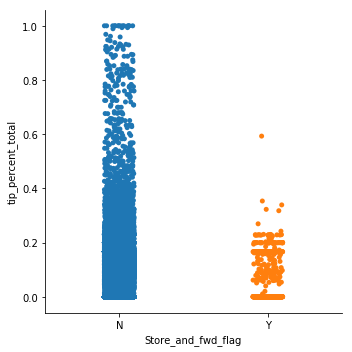

In [40]:
print("{:.2f}% of the data have 'Y' for 'Store_and_fwd_flag' field"
      .format(100 * sum(data.Store_and_fwd_flag == 'N')/len(data)))
print('-'*90)
print('''Although only less than 1% of the data have 'N' value for 'Store_and_fwd_flag', 
from the comparison plot below, we can still see the usefulness of this variable at 
predicting tip as a percentage of total fare.
''')
ax = sns.catplot(x = 'Store_and_fwd_flag', y = 'tip_percent_total', data = sample_data)
ax;


In [41]:
# Extract columns of interest
sample_interest = sample_data.drop(['lpep_pickup_datetime','lpep_dropoff_datetime',
                                    'Ehail_fee','Tip_amount','Total_amount'], axis = 1)

##### `VendorID`, `RateCodeID`, `Payment_type` and `Trip_type`

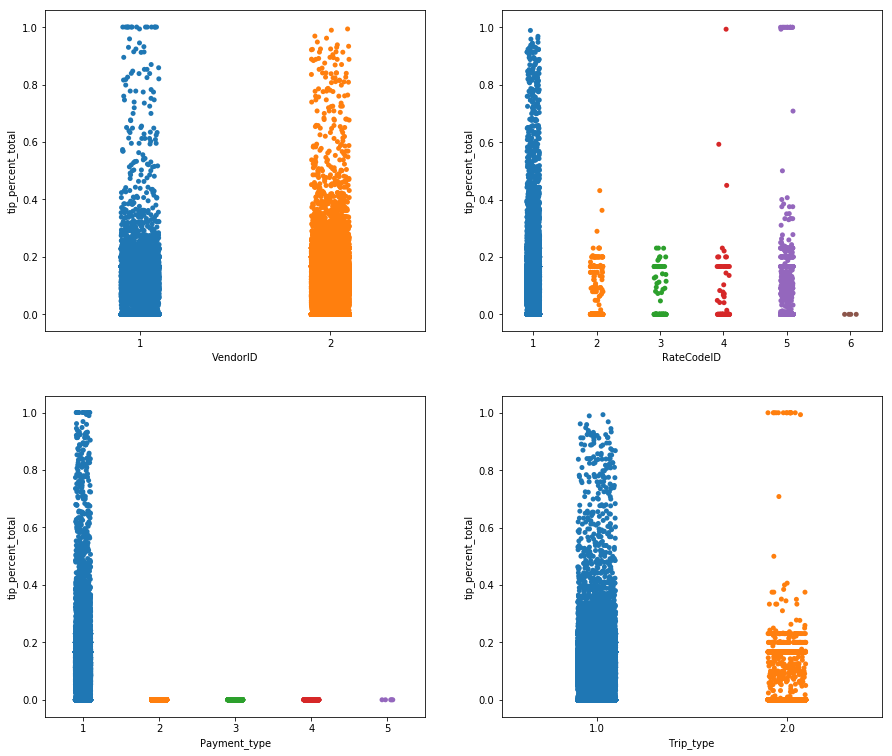

In [42]:
# Create four subplots (2x2)
fig, ax = plt.subplots(2,2,figsize=(15,13))
# Create visualizations for tip_percent_total by different group
sns.catplot(x = 'VendorID', y = 'tip_percent_total', data = sample_interest, ax = ax[0][0])
sns.catplot(x = 'RateCodeID', y = 'tip_percent_total', data = sample_interest, ax = ax[0][1])
sns.catplot(x = 'Payment_type', y = 'tip_percent_total', data = sample_interest, ax = ax[1][0])
sns.catplot(x = 'Trip_type', y = 'tip_percent_total', data = sample_interest, ax = ax[1][1])
# Close extra empty grids
plt.close(2);plt.close(3);plt.close(4);plt.close(5);

**Summary**: From the four plots above, we can see data from different groups do seem to have difference, more or less, on the value of `tip_percent_total`. The differences are expecially noticeable for different groups from `Payment_type` (Different ways of paying the trip) and `RateCodeID` (Different route of trip)

##### `Pickup_latitude`, `Pickup_longitude`, `Dropoff_latitude` and `Dropoff_longitude`

In [43]:
print(sample_interest[['Pickup_latitude','Pickup_longitude','Dropoff_latitude','Dropoff_longitude']].describe())
print('-'*80)
print('''From the summary statistics in the table above, 
I noticed that both latitude and longitude for eith pick-up or drop-off
have values of zeroes, which is technically impossible to happen in NYC area.
Therefore, I exclude any coordinates with zero values for the next visualization.
      ''')

       Pickup_latitude  Pickup_longitude  Dropoff_latitude  Dropoff_longitude
count    148834.000000     148834.000000     148834.000000      148834.000000
mean         40.698164        -73.843783         40.697569         -73.845872
std           1.433014          2.598389          1.409487           2.555867
min           0.000000        -74.891777          0.000000         -74.891777
25%          40.699219        -73.959534         40.698988         -73.967972
50%          40.746662        -73.945480         40.747187         -73.945076
75%          40.802265        -73.917419         40.789847         -73.910088
max          42.402088          0.000000         42.402054           0.000000
--------------------------------------------------------------------------------
From the summary statistics in the table above, 
I noticed that both latitude and longitude for eith pick-up or drop-off
have values of zeroes, which is technically impossible to happen in NYC area.
Therefore, I exclu

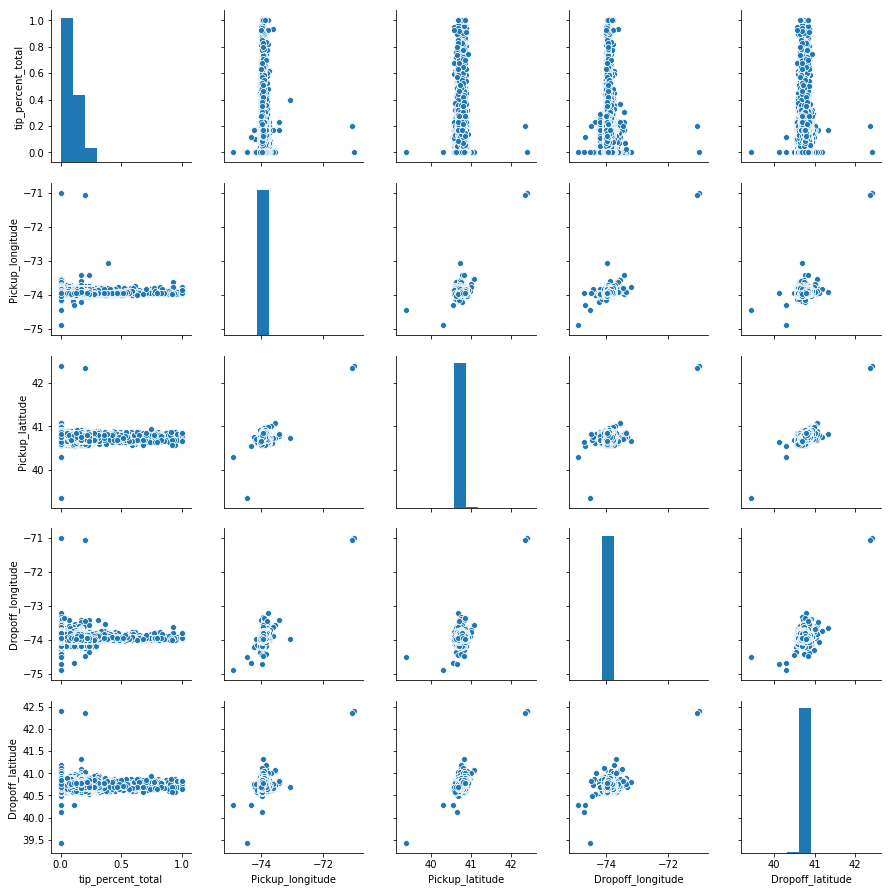

In [44]:
# Pair plot of tip_percent_total and all GPS coordinates
invalid_gps = ((sample_interest.Pickup_latitude == 0)|
               (sample_interest.Pickup_longitude == 0)|
               (sample_interest.Dropoff_latitude == 0)|
               (sample_interest.Dropoff_longitude == 0))
# Plot the relationships between tip_percent_total and GPS coordinates
ax = sns.pairplot(sample_interest.loc[~invalid_gps,['tip_percent_total','Pickup_longitude',
                                                     'Pickup_latitude','Dropoff_longitude',
                                                     'Dropoff_latitude']])
ax;

**Summary**: By looking at graphs in the first column, I notice that trips that pick-up/drop-off from places that are far from the urban area tend to have lower tip as a percentage of total fare.

##### `Passenger_count` and `Trip_distance`

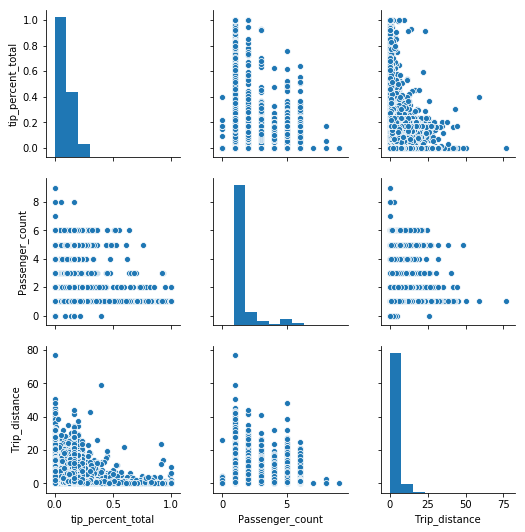

In [45]:
# Plot the relationships between tip_percent_total and Passenger_count, Trip_distance
ax = sns.pairplot(sample_interest.loc[:,['tip_percent_total','Passenger_count','Trip_distance']])
ax;

**Summary**: By looking at graphs in the first column, I notice that

- The value of `tip_percent_total` tends to become smaller as the number of passengers increases 
- High values of `tip_percent_total` are mostly from trips with short distance, while long distance trips barely come with high tip as a percent of total fare

##### `Extra`, `MTA_tax`, `Tolls_amount` and `improvment_surcharge`

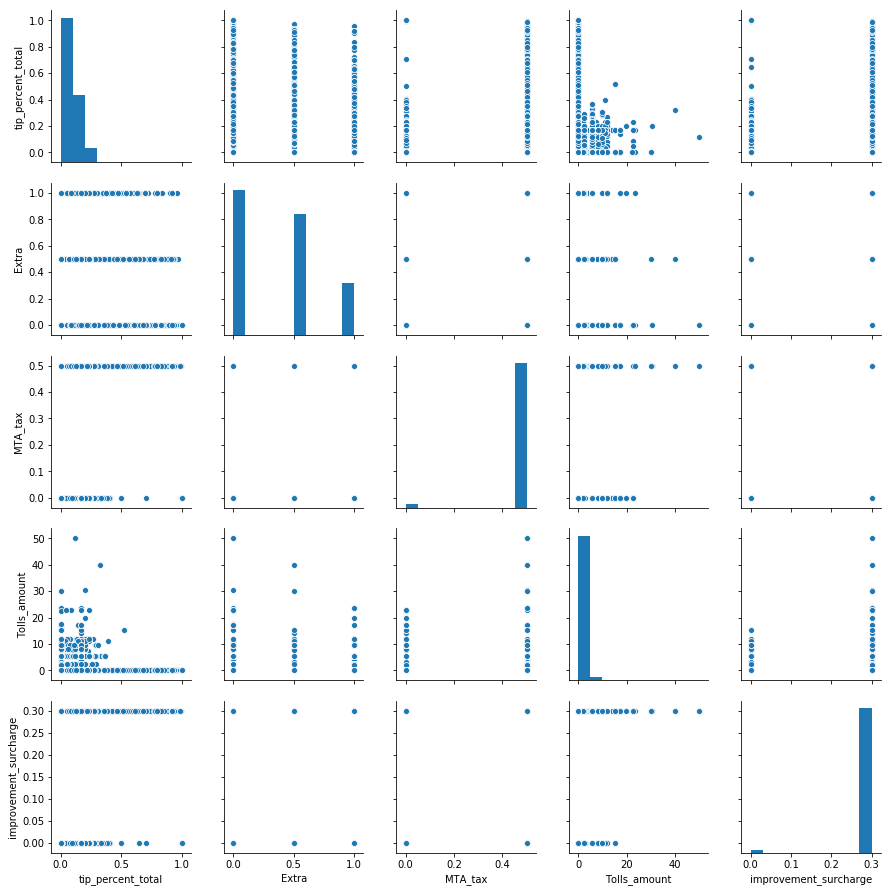

In [46]:
# Plot the relationships between tip_percent_total and Passenger_count, Trip_distance
ax = sns.pairplot(sample_interest.loc[:,['tip_percent_total','Extra','MTA_tax','Tolls_amount',
                                         'improvement_surcharge']])
ax;

**Summary**: By looking at graphs in the first column, I notice that except `Extra` (Miscellaneous extras and surcharges) that do not seem to have any relationship with `tip_percent_total`, the rest variables are useful

- Trips with zero `MTA_tax` or `improvement_surcharge` tend to come with lower tip as a percentage of total fare
- Trips with high `Tolls_amount` tend to have lower tip as a percentage of total fare

##### `lpep_pickup_hour` and `lpep_dropoff_hour`

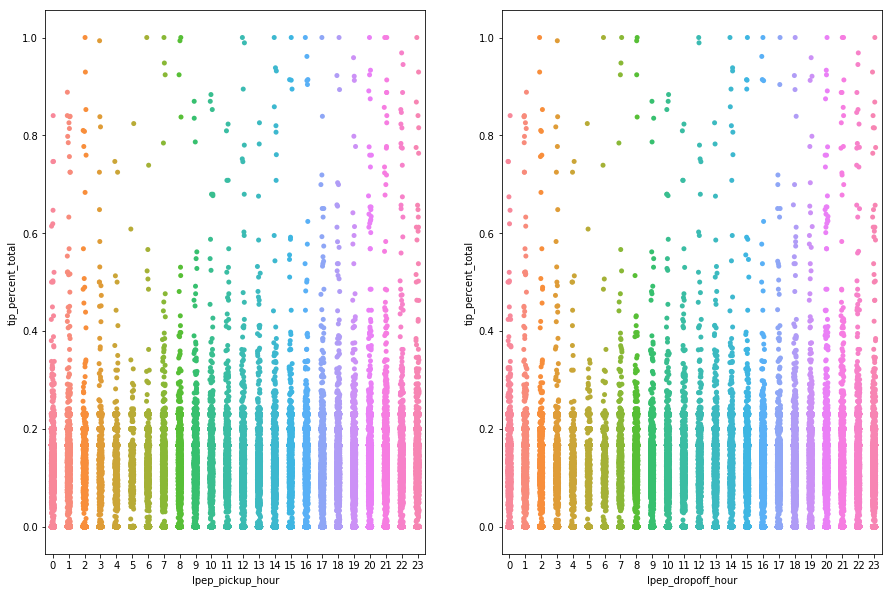

In [47]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,10))
# Create visualizations for tip_percent_total by different group
sns.catplot(x = 'lpep_pickup_hour', y = 'tip_percent_total', data = sample_interest, ax = ax[0])
sns.catplot(x = 'lpep_dropoff_hour', y = 'tip_percent_total', data = sample_interest, ax = ax[1])# Close extra empty grids
plt.close(2);plt.close(3);

##### `lpep_pickup_day` and `lpep_dropoff_day`

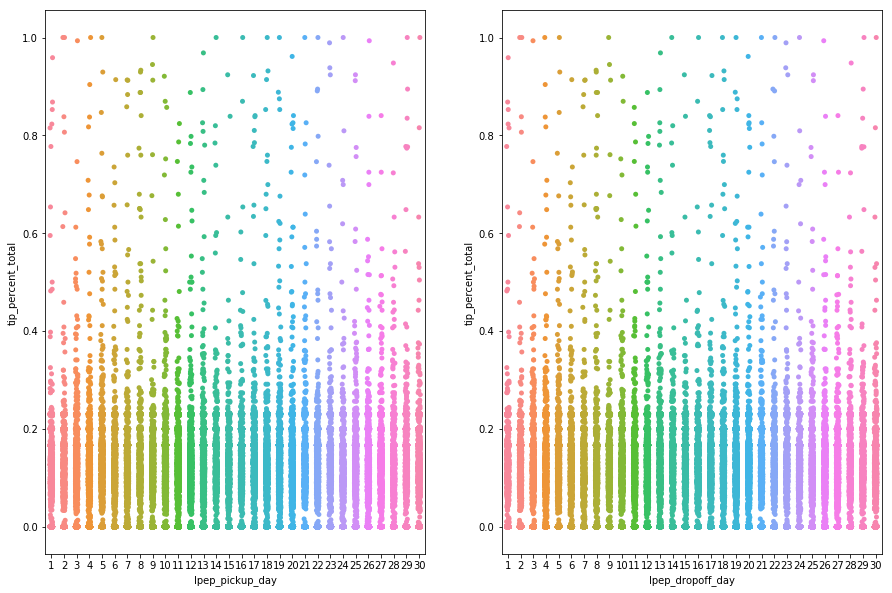

In [48]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,10))
# Create visualizations for tip_percent_total by different group
sns.catplot(x = 'lpep_pickup_day', y = 'tip_percent_total', data = sample_interest, ax = ax[0])
sns.catplot(x = 'lpep_dropoff_day', y = 'tip_percent_total', data = sample_interest, ax = ax[1])# Close extra empty grids
plt.close(2);plt.close(3);

##### `mile_per_hour`

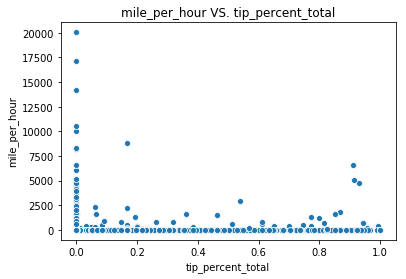

In [49]:
# Plot the relationships between tip_percent_total and Passenger_count, Trip_distance
ax = sns.scatterplot(sample_interest.tip_percent_total, sample_interest.mile_per_hour)
ax.set_title('mile_per_hour VS. tip_percent_total');

**Summary**: Based on the three sets of plots above, `lpep_pickup_hour`, `lpep_dropoff_hour`,`lpep_pickup_day`, `lpep_dropoff_day` and `mile_per_hour` all seem to have some relationship with `tip_percent_total`

### Step 2. Data Cleaning

Since the data contains records that are suspicious to be inaccurate or incorrect, it is important to clean the dataset before using it for model training

To summarize, following filters will be applied to the dataset

1. `Trip_distance < 60`: Refer to the report in Question 2, part (2)
2. `tip_percent_total >= 0`: Refer to Question 4, data with suspiciously incorrect values of `Total_amount` and `Tip_amount` will result in value of $-999.0$ from the calculation
3. `mile_per_hour <= 100`: Refer to Question 4, part (2), the distribution is highly right skewed due to extreme values from suspicious incorrect records
4. `Pickup_latitude != 0`: valid GPS coordinate
5. `Pickup_longitude != 0`: valid GPS coordinate
6. `Dropoff_latitude != 0`: valid GPS coordinate
7. `Dropoff_longitude != 0`: valid GPS coordinate


In [50]:
# Data cleaning
valid_data = data.query('Trip_distance < 60 and tip_percent_total >= 0 and mile_per_hour <= 100')
valid_data = valid_data.query('Pickup_latitude != 0 and Pickup_longitude != 0')
valid_data = valid_data.query('Dropoff_latitude != 0 and Dropoff_longitude != 0')
# Compute the proportion of the data that is removed
print('{:.2f}% of the data is removed from the dataset after cleaning.'.format(100 * (1 - len(valid_data)/len(data))))

0.84% of the data is removed from the dataset after cleaning.


### Step 3. Model Training

I will build a simple XGBoost model as a baseline for prediction of tip of a percentage of total fare

**Note**: One-Hot Encoding is used on categorical variables in order to train the XGBoost model

In [51]:
# Extract categorical data
categorical_data = valid_data.select_dtypes(include = ['object'])

In [52]:
# Extract numerical data
numerical_data = valid_data.select_dtypes(exclude = ['object'])
# Drop variables that will not be used
numerical_data.drop(['lpep_pickup_datetime','lpep_dropoff_datetime',
                     'Ehail_fee','Tip_amount','Total_amount'], axis = 1, inplace = True)

In [53]:
# One hot encoding for categorical data
encoded_x = None
for i in range(0, categorical_data.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(categorical_data.iloc[:,i])
    feature = feature.reshape(categorical_data.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = np.concatenate((encoded_x, feature), axis=1)

In [54]:
# Reset the cateogircal_data with one-hot encoded values
categorical_data = pd.DataFrame(encoded_x, columns = ['VendorID_1','VendorID_2',
                                       'Store_and_fwd_flag_N','Store_and_fwd_flag_Y',
                                       'RateCodeID_1','RateCodeID_2','RateCodeID_3',
                                       'RateCodeID_4','RateCodeID_5','RateCodeID_6',
                                       'Payment_type_1','Payment_type_2','Payment_type_3',
                                       'Payment_type_4','Payment_type_5',
                                       'Trip_type_1','Trip_type_2'], index = categorical_data.index)

In [55]:
# Combine numerical and categorical data
one_hot_data = pd.concat([numerical_data, categorical_data], axis = 1)

In [56]:
# Split data into train and test sets
[x_train, x_test, y_train, y_test] = train_test_split(one_hot_data.drop(['tip_percent_total'], axis = 1), 
                                                      one_hot_data.loc[:,'tip_percent_total'], 
                                                      test_size = 0.3, random_state = seed)

In [57]:
# Set parameters for XGBoost
parameter = {'objective': 'reg:linear',
             'colsample_bytree': 0.8,
             'learning_rate': 0.1,
             'n_estimator': 100,
             'silent': 1,
             'seed': seed
            }
# Number of data used for training (Used 100,000 data for fast training)
train_num = 100000
# Train the XGBoost with 5-folde cross validation
xgb_cv_tip = xgb.cv(dtrain = xgb.DMatrix(x_train[0:train_num], y_train[0:train_num]), 
                    params = parameter, nfold = 5, num_boost_round = 1000, 
                    early_stopping_rounds = 100, metrics = 'rmse', as_pandas = True, 
                    seed = seed, verbose_eval = 10, show_stdv = False)

[0]	train-rmse:0.398212	test-rmse:0.398228
[10]	train-rmse:0.146292	test-rmse:0.146604
[20]	train-rmse:0.0680726	test-rmse:0.0690724
[30]	train-rmse:0.0504	test-rmse:0.0520974
[40]	train-rmse:0.0475012	test-rmse:0.0495714
[50]	train-rmse:0.0468726	test-rmse:0.0492126
[60]	train-rmse:0.0466196	test-rmse:0.0491586
[70]	train-rmse:0.0464198	test-rmse:0.04915
[80]	train-rmse:0.0462502	test-rmse:0.0491432
[90]	train-rmse:0.0460752	test-rmse:0.049148
[100]	train-rmse:0.0459128	test-rmse:0.0491512
[110]	train-rmse:0.045753	test-rmse:0.0491442
[120]	train-rmse:0.0455914	test-rmse:0.0491484
[130]	train-rmse:0.0454416	test-rmse:0.049159
[140]	train-rmse:0.0452966	test-rmse:0.0491606
[150]	train-rmse:0.0451628	test-rmse:0.0491856
[160]	train-rmse:0.045029	test-rmse:0.0491972
[170]	train-rmse:0.0448964	test-rmse:0.0492118
[180]	train-rmse:0.044761	test-rmse:0.0492158


Since the model stop training after $190$ rounds in the cross-validation above, to be conservative, I pick $500$ as the number of trees for the sake of faster training below

In [58]:
# Set parameters for 
xgb_model_tip = xgb.XGBRegressor(objective = 'reg:linear', 
                                 n_estimators = 500,
                                 colsample_bytree = 0.8,
                                 learning_rate = 0.1,
                                 reg_alpha = 0.3,
                                 silent = True,
                                 seed = seed)
# Record start time
start = time.time()
# Fit the model on training data
xgb_model_tip.fit(x_train[0:train_num], y_train[0:train_num])
# Record end time
end = time.time()
print('XGBoost model took {} minutes to train'.format((end - start)/60))

XGBoost model took 0.6987334132194519 minutes to train


In [59]:
print('RMSE for {} test data: {:.5f}'
      .format(len(y_test),
              np.sqrt(metrics.mean_squared_error(y_test, xgb_model_tip.predict(x_test)))))

RMSE for 444722 test data: 0.04945


**Summary**: Trained with **500** bossted trees, learning rate of **0.1**, as well as slight L1 regularization on **100,000** records, the XGBoost model can achieve RMSE of **0.04944** on the test dataset of size **444,722**.

# Question 5 (Distribution)

## (1) Build a derived variable representing the average speed over the course of a trip.

The variable created before `mile_per_hour` can be used as a measure of the average speed

## (2) Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

In [60]:
# Find the week number based on pickup timestamp
valid_data['week_of_year'] = [date.isocalendar()[1] for date in valid_data.lpep_pickup_datetime]
print('Week of Year: {}'.format(valid_data.week_of_year.unique()))

Week of Year: [36 37 38 39 40]


In [61]:
# Subset mile_per_hour by week number
week_1 = valid_data.loc[valid_data.week_of_year == 36,'mile_per_hour']
week_2 = valid_data.loc[valid_data.week_of_year == 37,'mile_per_hour']
week_3 = valid_data.loc[valid_data.week_of_year == 38,'mile_per_hour']
week_4 = valid_data.loc[valid_data.week_of_year == 39,'mile_per_hour']
week_5 = valid_data.loc[valid_data.week_of_year == 40,'mile_per_hour']

Since we are interested in knowing whether the average trip speeds are the same in all weeks of September, it is reasonable to perform one-way ANOVA test to test our hypothesis

In [62]:
# Perform ANOVA test
stats.f_oneway(week_1, week_2, week_3, week_4, week_5)

F_onewayResult(statistic=966.8362926960675, pvalue=0.0)

Based on the result from one-way ANOVA, there is no reason to doubt that the average trip speeds are not the same in all weeks of September due to the **p-value of 0.0**

Furthermore, I performed the Tukey's test to check the differences in the average trip speeds between every pair of weeks

In [63]:
# Tukey's test
tukey = pairwise_tukeyhsd(endog = valid_data[valid_data.mile_per_hour <= 100].mile_per_hour, 
                          groups = valid_data[valid_data.mile_per_hour <= 100].week_of_year,
                          alpha = 0.05)
# Get the result summary
tukey.summary()

group1,group2,meandiff,lower,upper,reject
36,37,-0.6633,-0.7034,-0.6232,True
36,38,-0.6646,-0.7048,-0.6243,True
36,39,-0.1954,-0.2362,-0.1545,True
36,40,-0.8576,-0.9114,-0.8039,True
37,38,-0.0013,-0.0395,0.037,False
37,39,0.4679,0.4291,0.5068,True
37,40,-0.1943,-0.2466,-0.1421,True
38,39,0.4692,0.4303,0.5082,True
38,40,-0.193,-0.2454,-0.1407,True
39,40,-0.6623,-0.715,-0.6095,True


From the summary table above, we can see that **we reject the null hypothesis ($H_o$: Average Trip Speeds Are the Same) for every pair of weeks, except 37 and 38, at a significance level of 0.05**. Hence, it is safe to conclude that the average trip speeds are only the same for the $2^{nd}$ (37) and $3{rd}$ (38) week of September 2015. Other pairs of weeks **DO NOT** have the same average trip speeds.

The differences are also visible if we plot the distribution of `mile_per_hour` for different week in a limited range of [0,20]

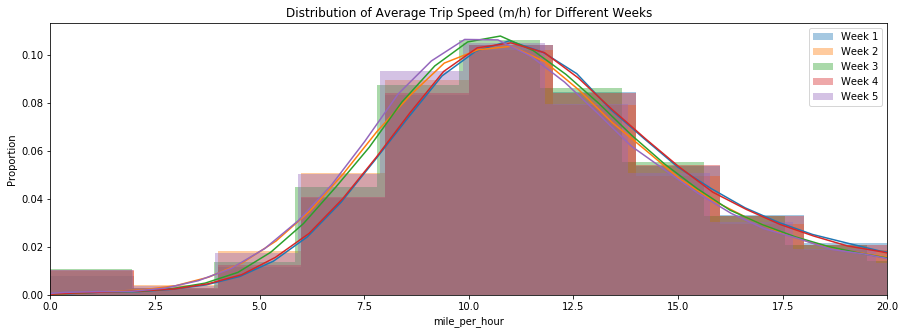

In [64]:
# Plot average trip speeds for different weeks
fig, ax = plt.subplots(figsize = (15,5))
sns.distplot(week_1, ax = ax)
sns.distplot(week_2, ax = ax)
sns.distplot(week_3, ax = ax)
sns.distplot(week_4, ax = ax)
sns.distplot(week_5, ax = ax)
ax.legend(['Week 1','Week 2','Week 3','Week 4','Week 5']); ax.set_ylabel('Proportion');
ax.set_title('Distribution of Average Trip Speed (m/h) for Different Weeks'); 
ax.set_xlim(0,20);

## (3) Can you build up a hypothesis of average trip speed as a function of time of day?

In [65]:
# Split data into train and test sets
predictors = ['lpep_pickup_hour','lpep_dropoff_hour',
              'lpep_pickup_day','lpep_dropoff_day',
              'week_of_year']
[x_train, x_test, y_train, y_test] = train_test_split(valid_data.loc[:, predictors], 
                                                      valid_data.loc[:,'tip_percent_total'], 
                                                      test_size = 0.3, random_state = seed)

In [66]:
# Set parameters for XGBoost
parameter = {'objective': 'reg:linear',
             'colsample_bytree': 0.8,
             'learning_rate': 0.1,
             'n_estimator': 100,
             'silent': 1,
             'seed': seed
            }
# Number of data used for training (Used 100,000 data for fast training)
train_num = 100000
# Train the XGBoost with 5-folde cross validation
xgb_cv_speed = xgb.cv(dtrain = xgb.DMatrix(x_train[0:train_num], y_train[0:train_num]), 
                      params = parameter, nfold = 5, num_boost_round = 1000, 
                      early_stopping_rounds = 100, metrics = 'rmse', as_pandas = True, 
                      seed = seed, verbose_eval = 10, show_stdv = False)

[0]	train-rmse:0.39949	test-rmse:0.39949
[10]	train-rmse:0.161928	test-rmse:0.161962
[20]	train-rmse:0.0998854	test-rmse:0.100027
[30]	train-rmse:0.0893596	test-rmse:0.0896082
[40]	train-rmse:0.0879248	test-rmse:0.0882498
[50]	train-rmse:0.0876926	test-rmse:0.0880798
[60]	train-rmse:0.087619	test-rmse:0.0880598
[70]	train-rmse:0.0875712	test-rmse:0.0880596
[80]	train-rmse:0.0875236	test-rmse:0.0880654
[90]	train-rmse:0.0874846	test-rmse:0.088075
[100]	train-rmse:0.0874488	test-rmse:0.0880844
[110]	train-rmse:0.0874174	test-rmse:0.0880924
[120]	train-rmse:0.0873914	test-rmse:0.0881026
[130]	train-rmse:0.0873652	test-rmse:0.0881126
[140]	train-rmse:0.0873412	test-rmse:0.0881218
[150]	train-rmse:0.0873208	test-rmse:0.0881302
[160]	train-rmse:0.0873016	test-rmse:0.08814


Since the model stop training after $160$ rounds in the cross-validation above, to be conservative, I pick $500$ as the number of trees for the sake of faster training below

In [67]:
# Set parameters for 
xgb_model_speed = xgb.XGBRegressor(objective = 'reg:linear', 
                                   n_estimators = 500,
                                   colsample_bytree = 0.8,
                                   learning_rate = 0.1,
                                   reg_alpha = 0.3,
                                   silent = True,
                                   seed = seed)
# Record start time
start = time.time()
# Fit the model on training data
xgb_model_speed.fit(x_train[0:train_num], y_train[0:train_num])
# Record end time
end = time.time()
print('XGBoost model took {} minutes to train'.format((end - start)/60))

XGBoost model took 0.15191046396891275 minutes to train


In [68]:
print('RMSE for {} test data: {:.5f}'
      .format(len(y_test),
              np.sqrt(metrics.mean_squared_error(y_test, xgb_model_speed.predict(x_test)))))

RMSE for 444722 test data: 0.08785


**Summary**: By training XGBoost model with **500** bossted trees, learning rate of **0.1**, as well as slight L1 regularization on **100,000** records. The model can achieve RMSE of **0.08785** on the test dataset of size **444,722**.

# Future Work

**1. More parameter tuning on XGBoost**

For the sake of fast training, I only set a few parameters for the XGBoost model and performed a 5-fold cross-validation. More fine tuning on the parameters can very likely yield superior results

**2. Increase the Size of Training Data** 

Due to computational limitation, I only used 10,000 records from originally planned 1,037,683 training data records. The performance of the model is expected to increase with more training data to better represent the population

**3. More Feature Engineering**

Although I did quite a few filtering and transformation of the variables, there are still a lot more feature engineering can be done and tested, which I did not have enough time to try all of them. Some ideas include

- Create geolocation blocks based on geo-fence, which can be calcualted from the longitude and latitude. Generate summary information for every blocks such as `avergae income`, `population density` and etc., to help with assess the quantity and quality of passengers
- Investigate the suspicous values to find out the actual reasons behind them. Edit those values based on the investigation results

In addition, the very basic feature engineering to do is performing variable selection based on the feature importance

```python
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(xgb_model_tip, ax= ax)
ax;
```

![](feature_importance.png)

**4. Test Models that are not Tree-based**

Both models used above are XGBoost which is a tree-base model. It is worthwhile to test the performance of other types of model such as Elastic Net, Nerual Nets, and etc.

**5. Ensemble Different Models**

An intuitive follow step after testing more models is to create an ensemble model to combine the power of different types of model.







